<a href="https://colab.research.google.com/github/fnal-cpc/bootcamp/blob/master/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Fitting in Python with Scipy

This is a tutorial on scientific Python largely taken from the [KIPAC computing boot camp](http://kipac.github.io/BootCamp) and updated for the CPC Bootcamp.

Authors: [Sean McLaughlin](http://github.com/mclaughlin6464), [Joe Derose](http://github.com/j-dr), Noah Kurinsky

Model fitting is one of the most common and important things researchers have to do. There is not a one-size-fits-all solution to all model fitting problems, however. For example:
* Perhaps we need to a fit a relatively simple model to a large dataset (or a large number of smaller datasets) and we want the fit to be efficient
* Maybe we don't know what kind of model we need so we want to be able to easily compare a suite of models
* Perhaps the model fit is our entire analyis, and we need to understand all uncertainties and correlations very well

We will look at Python packages that handle different situations like these.

First though, we'll need some data to fit! We'll generate two datasets, a simple linear dataset and a slightly more complex nonlinear model. 

In [0]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
true_m, true_b = 0.68, 2.38
N = 100
x = np.linspace(0,50,N)

def linear_func(x, m=true_m, b=true_b):
    return m*x+b

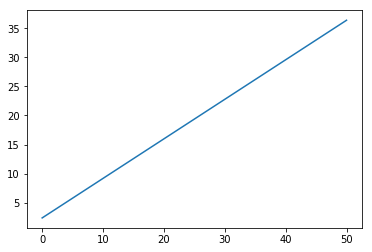

In [3]:
true_linear_y = linear_func(x)
plt.plot(x, true_linear_y)
plt.show()

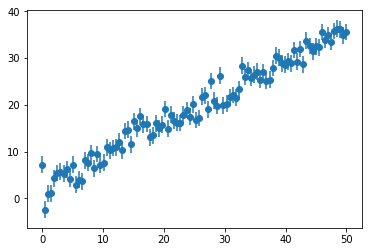

In [0]:
# add noise
sigma = 1.8
obs_linear_y = true_linear_y+ np.random.randn(N)*sigma
plt.errorbar(x, obs_linear_y, yerr = np.ones(N)*sigma,marker='o', ls='None')
plt.show()

In [0]:
true_p1, true_p2, true_p3, true_p4, true_p5 = -2.1, 0.8, -0.021, 4.3, 0.6
true_nonlinear_params = np.array([true_p1, true_p2, true_p3, true_p4, true_p5])
def nonlinear_func(x,p1=true_p1,p2=true_p2,p3=true_p3,p4=true_p4,p5=true_p5):
    # define a complex nonlinear function to fit
    return p1+p2*x+p3*x*x+p4*np.sin(x*p5)

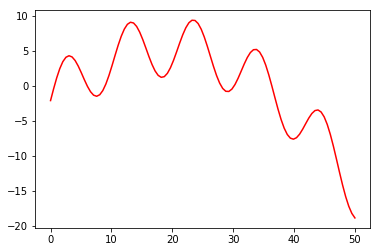

In [0]:
true_nonlinear_y = nonlinear_func(x)
plt.plot(x, true_nonlinear_y, color = 'r')

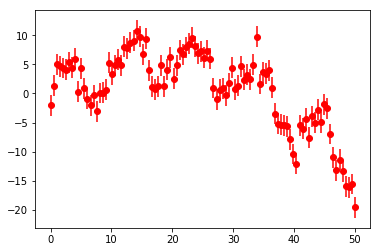

In [0]:
# add noise
obs_nonlinear_y = true_nonlinear_y+ np.random.randn(N)*sigma
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o', ls='None', color = 'r')
plt.show()

## Scipy
----
NumPy contains much of the functionality required to perform efficient operations in python, but you will soon realize that there is not a great deal of high level functionality implemented in numpy. 

[Scipy](http://docs.scipy.org/doc/scipy/reference/) is the module where you *will* find a great deal of high level functionality that is very useful for day to day scientific computing. 

Some of the very useful submodules that can be found in SciPy are:

* [Linear Algebra](http://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html)
* [Statistics](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
* [Integration](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)
* [Interpolation](http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)
* [FFT](http://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html)
* [Optimization](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

Today we be delving into some of the details of Linear Algebra and Optimization, but keep in mind that you will find similar depth in these other applications

We'll start with a simple linear system. Scipy has a great many useful linear algebra functions, including inverses, determinants, and eigenvalues! We can showcase some of these with a dummy matrix. 

In [0]:
A = np.eye(4)
A[1,2] = 3 # just to keep it interesting
print(A)

[[1. 0. 0. 0.]
 [0. 1. 3. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [0]:
from scipy.linalg import inv, det, eigvals

In [0]:
print(inv(A), det(A), eigvals(A))

(array([[ 1., -0.,  0., -0.],
       [ 0.,  1., -3., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0.,  1.]]), 1.0, array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]))


We will focus on the linear least squares solver in scipy. Recall that linear least squares finds the solution $\hat{x}$ to the system

$$ \mathbf{A}x = \mathbf{b} $$ 

that minimizes the squared absolute error. 

$$ \left\lVert \mathbf{A}x - b \right \rVert^2 $$

In the special case that your data satisfies the [Gauss-Markov Theroem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) (which ours do) the linear least squares solution will give the optimal unbiased estimator $\hat{x}$. Let's try it out on our linear model. 

In [0]:
from scipy.stats import linregress
from scipy.linalg import lstsq

fit_m, fit_b, r,p, std_err = linregress(x, obs_linear_y)
print('R^2 = ',r**2)
print('Fit:', fit_m, fit_b)
print('Truth:', true_m, true_b)

('R^2 = ', 0.9649870371185701)
('Fit:', 0.6750852538341671, 2.4609769207652796)
('Truth:', 0.68, 2.38)


The standard error is not an estimate of the error on the data points; it is used for estimating uncertanties in parameter estimates. To estimate sigma one can use this formula ( I found on Wikipedia)! 

In [0]:
print(np.sqrt(np.sum((obs_linear_y - linear_func(x, fit_m, fit_b))**2)/(N)))

1.874712972093328


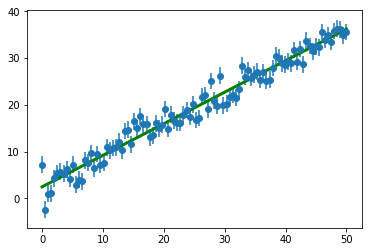

In [0]:
plt.errorbar(x, obs_linear_y, yerr = np.ones(N)*sigma,marker='o', ls='None')
plt.plot(x, fit_m*x+fit_b, color = 'g', lw = 3)
plt.show()

I actually used `scipy.stats`'s `linregress` module here instead of `lstsq`. That will give us the same answer, but with a few extra steps.  

In [0]:
A = np.ones((N,2))
A[:,1] = x #build a design matrix

(fit_b2, fit_m2), _,_,_ = lstsq(A, obs_linear_y)
print(fit_m2, fit_b2)

(0.6750852538341671, 2.460976920765284)


Why the extra steps? Well, that's because **linear least squares is not just for fitting lines**! Any linear model can be fit with linear least squares. Let's try that for our next excercise! 

### Exercise 1
Use linear least squares to fit to our nonlinear model. You'll have to assume that we know `true_p5` perfectly; all other parameters are linear. You'll have to start by making a design matrix, which will be similar to the matrix A above.  

---

Linear least squares works well for linear problems (which is not just lines!) But of course this is not all problems. Indeed, even for Excercise 1, we had to assume we knew a nonlinear parameter. How would we go about fitting for parameters like these? 

This is in general a much harder than linear optimization. If you have a consistent solution that works in all cases let me know and maybe we can share a Fields medal!

We will focus on two techniques that are commonly used in scipy: `curve_fit` (which uses [nonlinear least squares](http://mathworld.wolfram.com/NonlinearLeastSquaresFitting.html) )and `minimize` (which uses a variety of gradient descent-esque methods). 

In [0]:
from scipy.optimize import curve_fit, minimize

We'll start with [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which has an easy to use interface. To use curve fit, we'll have to a define a function (which we've already done) and give an initial guess. 

In [0]:
initial_guess = np.array([-1, 1, 0, 3, 0.4])
popt, pcov = curve_fit(nonlinear_func, x, obs_nonlinear_y, p0=initial_guess)
print(popt)
print(true_nonlinear_params)

[ 0.03971139  0.6852935  -0.01968813 -0.30427894  0.24764961]
[-2.1    0.8   -0.021  4.3    0.6  ]


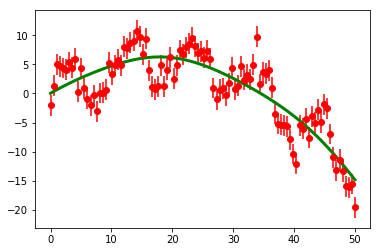

In [0]:
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *popt), color = 'g', lw = 3)
plt.show()

Hm, this did ok, but not great. This is hard! In general you may want to try several guesses if you're unsatisfied. In this case, since we know the truth, we can make an unreasonably good guess. We can also add some uncertainty information that we have. 

In [0]:
initial_guess = np.array([-2, 1, 0, 4, 0.55])
popt, pcov = curve_fit(nonlinear_func, x, obs_nonlinear_y, p0=initial_guess, sigma=np.ones(N)*sigma)
print(popt)
print(true_nonlinear_params)

[-1.02950054  0.74785062 -0.02038893  4.09177722  0.60015125]
[-2.1    0.8   -0.021  4.3    0.6  ]


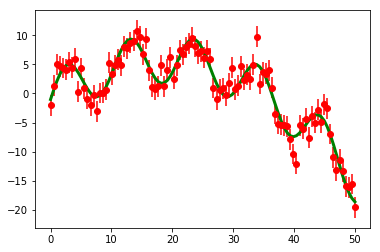

In [0]:
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *popt), color = 'g', lw = 3)
plt.show()

We also got a covariance matrix from the estimator. Let's use it now to calculates some uncertanties on our params.

In [0]:
errors = np.sqrt(np.diag(pcov))
for i,(p, e) in enumerate(zip(popt, errors)):
    print('Param {} = {} +/-{}'.format(i+1,p,e))

Param 1 = -1.02950054426 +/-0.544662654069
Param 2 = 0.747850616793 +/-0.0504542971246
Param 3 = -0.0203889333252 +/-0.000980301126233
Param 4 = 4.09177722058 +/-0.26095371473
Param 5 = 0.600151254523 +/-0.00228395589735


Let's move onto [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Minimize has a bit of a different use case; it seeks to minimize a function, rather than find a best fit. However, if we phrase our problem as a minimization, we can use it! Minimize supports several different optimization algorithms, depending on the nature of the problem. If you have access to bounds, constraints, or jacobian/hessians, you should use a function that exploits them. For now, we'll focus on the more basic ones. 

We'll begin by designing a **loss function**, which represents the loss that we want to minimize. We'll return to these again when we discuss MCMC. 

In [0]:
def loss_function(params, func, y_data, x_data):
    # just stick with a simple least squares
    return np.sum((y_data - func(x_data, *params))**2)

In [0]:
initial_guess = np.array([-1, 1, 0, 3, 0.4])
res = minimize(loss_function, initial_guess, args = (nonlinear_func, obs_nonlinear_y, x))

Minimze returns an object with results. We'll check if it thinks it was successful and see what the best guess was.

In [0]:
print(res.success)
print(res.x)
print(true_nonlinear_params)

False
[-1.02960714  0.74786361 -0.02038919  4.09178064  0.60015115]
[-2.1    0.8   -0.021  4.3    0.6  ]


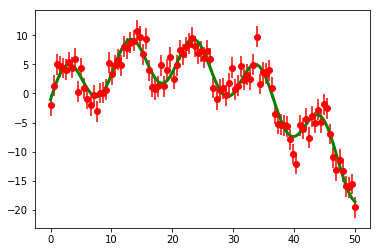

In [0]:
plt.errorbar(x, obs_nonlinear_y, yerr = np.ones(N)*sigma,marker='o',color='r', ls='None')
plt.plot(x, nonlinear_func(x, *res.x), color = 'g', lw = 3)
plt.show()

Damn. No luck. 

There's a lot of ways we could proceed here. Why don't we try it as an excercise? 

### Exercise 2
Find a good fit to the nonlinear data using minimize. You may want to try using a different method, or perhaps doing something fancy with your loss function (for example, regularizing). 